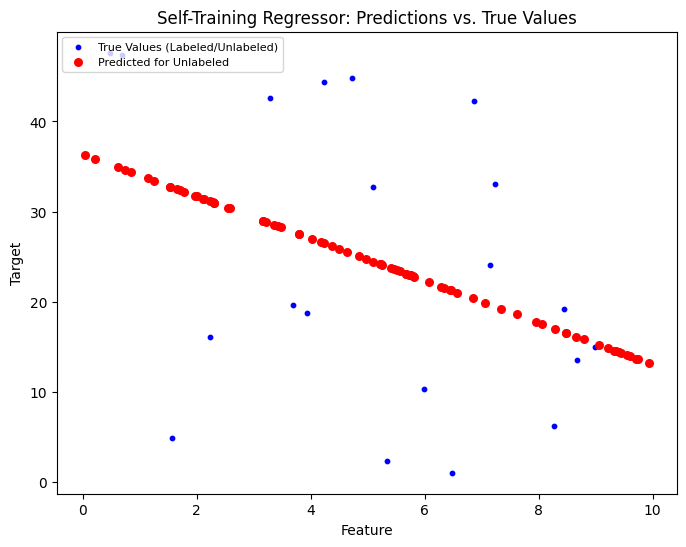

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Generate synthetic dataset with labeled and unlabeled data
X, y = np.random.rand(100, 1) * 10, np.random.rand(100) * 50
X, y = shuffle(X, y, random_state=42)
y[:80] = np.nan  # Unlabeled data

# Split into labeled and unlabeled data
X_labeled = X[~np.isnan(y)]
y_labeled = y[~np.isnan(y)]
X_unlabeled = X[np.isnan(y)]

# Define custom Self-Training Regressor
class SelfTrainingRegressor:
    def __init__(self, base_model, max_iter=10, threshold=0.1):
        self.base_model = base_model
        self.max_iter = max_iter
        self.threshold = threshold

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        self.base_model.fit(X_labeled, y_labeled)  # Train on initial labeled data
        X_all = np.vstack([X_labeled, X_unlabeled])
        y_all = np.hstack([y_labeled, np.full(X_unlabeled.shape[0], np.nan)])

        for _ in range(self.max_iter):
            # Predict on unlabeled data
            y_pred_unlabeled = self.base_model.predict(X_unlabeled)

            # Add confident predictions to labeled data
            confident_mask = np.abs(y_pred_unlabeled - np.nanmean(y_labeled)) < self.threshold
            if not np.any(confident_mask):
                break  # No confident predictions, stop training

            X_confident = X_unlabeled[confident_mask]
            y_confident = y_pred_unlabeled[confident_mask]

            # Update labeled and unlabeled datasets
            X_labeled = np.vstack([X_labeled, X_confident])
            y_labeled = np.hstack([y_labeled, y_confident])
            X_unlabeled = X_unlabeled[~confident_mask]

            # Retrain model
            self.base_model.fit(X_labeled, y_labeled)

        self.X_labeled = X_labeled
        self.y_labeled = y_labeled
        return self

    def predict(self, X):
        return self.base_model.predict(X)

# Train custom Self-Training Regressor
base_model = Ridge()
self_training_model = SelfTrainingRegressor(base_model, max_iter=10, threshold=5.0)
self_training_model.fit(X_labeled, y_labeled, X_unlabeled)

# Generate predictions for unlabeled data
y_pred_unlabeled = self_training_model.predict(X_unlabeled)

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='True Values (Labeled/Unlabeled)', s=10)
plt.scatter(X_unlabeled, y_pred_unlabeled, color='red', label='Predicted for Unlabeled', s=30)
plt.title("Self-Training Regressor: Predictions vs. True Values")
plt.legend(loc="upper left", fontsize=8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()


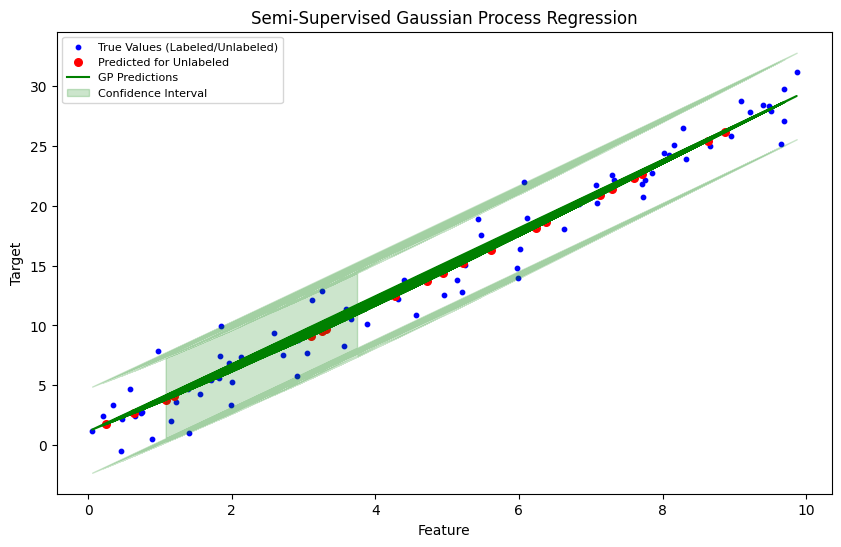

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Generate synthetic dataset
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Features
y = 3 * X.flatten() + np.random.randn(100) * 2  # Labels
y[80:] = np.nan  # Unlabeled data

# Separate labeled and unlabeled data
X_labeled = X[~np.isnan(y)]
y_labeled = y[~np.isnan(y)]
X_unlabeled = X[np.isnan(y)]

# Define kernel for Gaussian Process
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)

# Train Gaussian Process on labeled data
gp_model = GPy.models.GPRegression(X_labeled, y_labeled[:, None], kernel)
gp_model.optimize(messages=True)

# Make predictions for all data (including unlabeled)
X_all = np.vstack([X_labeled, X_unlabeled])
y_pred, y_var = gp_model.predict(X_all)

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='True Values (Labeled/Unlabeled)', s=10)
plt.scatter(X_unlabeled, y_pred[len(X_labeled):], color='red', label='Predicted for Unlabeled', s=30)
plt.plot(X_all, y_pred, color='green', label='GP Predictions')
plt.fill_between(
    X_all.flatten(),
    y_pred.flatten() - 1.96 * np.sqrt(y_var.flatten()),
    y_pred.flatten() + 1.96 * np.sqrt(y_var.flatten()),
    color="green",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Semi-Supervised Gaussian Process Regression")
plt.legend(loc="upper left", fontsize=8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()


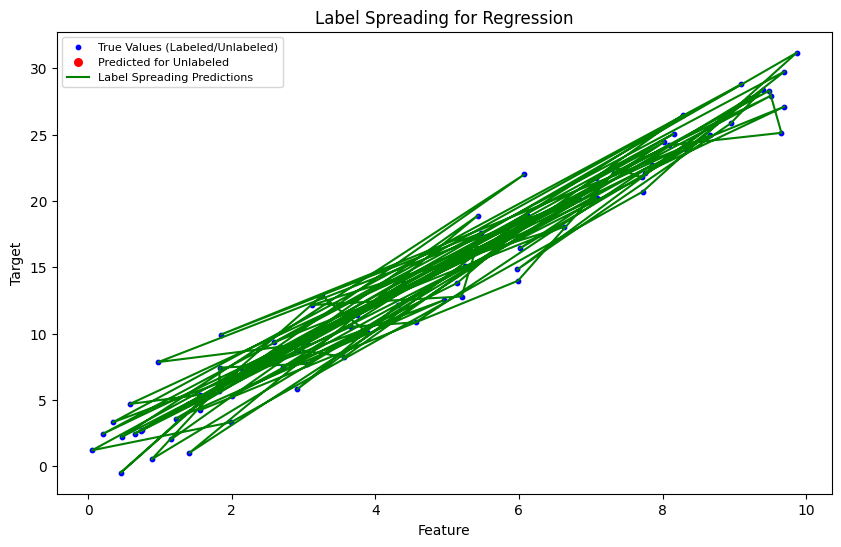

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize

# Generate synthetic dataset
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Features
y = 3 * X.flatten() + np.random.randn(100) * 2  # Labels
y[80:] = np.nan  # Unlabeled data

# Define RBF kernel function for similarity
def construct_similarity_matrix(X, gamma=0.1):
    W = rbf_kernel(X, X, gamma=gamma)
    return normalize(W, norm="l1", axis=1)

# Label spreading for regression
def label_spreading_regression(X, y, gamma=0.1, max_iter=100, tol=1e-4):
    W = construct_similarity_matrix(X, gamma=gamma)
    y_filled = np.copy(y)
    unlabeled_mask = np.isnan(y)
    
    for _ in range(max_iter):
        y_prev = np.copy(y_filled)
        y_filled = W @ y_filled  # Spread labels
        y_filled[~unlabeled_mask] = y[~unlabeled_mask]  # Keep labeled values fixed
        
        if np.linalg.norm(y_filled - y_prev) < tol:
            break
    
    return y_filled

# Apply Label Spreading for Regression
gamma = 0.1
y_filled = label_spreading_regression(X, y, gamma=gamma)

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='True Values (Labeled/Unlabeled)', s=10)
plt.scatter(X[np.isnan(y)], y_filled[np.isnan(y)], color='red', label='Predicted for Unlabeled', s=30)
plt.plot(X, y_filled, color='green', label='Label Spreading Predictions')
plt.title("Label Spreading for Regression")
plt.legend(loc="upper left", fontsize=8)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()


半监督回归模型 (Semi-Supervised Regression Models) 适用于部分数据有标签而大部分数据无标签的情况。它通过利用未标记数据的结构信息来提高预测性能。

---

### **半监督回归模型分类**

#### **1. Self-Training Regressor**
- **实现库**: Scikit-learn 提供
- **特点**:
  - 通过初始模型预测未标记数据的伪标签，然后用伪标签扩展训练集。
- **适用场景**:
  - 少量标记数据，未标记数据数量较多且与标记数据分布一致。
- **优缺点**:
  - **优点**: 实现简单，易于扩展。
  - **缺点**: 伪标签的错误可能会传播。

#### **2. Semi-Supervised Gaussian Process Regression**
- **实现库**: 使用扩展库或自定义实现
- **特点**:
  - 利用高斯过程对标记和未标记数据进行联合建模。
- **适用场景**:
  - 数据具有复杂非线性关系，且标记数据有限。
- **优缺点**:
  - **优点**: 能量化预测不确定性。
  - **缺点**: 对大规模数据计算效率较低。

#### **3. Label Spreading (回归扩展)**
- **实现库**: Scikit-learn 提供 (需适配回归任务)
- **特点**:
  - 通过图结构在标记和未标记数据之间传播标签信息。
- **适用场景**:
  - 数据之间的局部结构明显。
- **优缺点**:
  - **优点**: 利用数据的局部几何结构。
  - **缺点**: 需调整图的构造方式，计算复杂度高。

---

### **模型选型建议**

| **任务特点**                      | **推荐模型**                  |
|-----------------------------------|-------------------------------|
| 标记数据有限，未标记数据较多      | Self-Training Regressor       |
| 非线性关系显著，需预测不确定性    | Semi-Supervised Gaussian Process Regression |
| 数据之间具有局部结构              | Label Spreading for Regression |

---

### **扩展模型**
如果需要扩展到其他半监督回归模型，可以使用：
1. **扩展的高斯过程 (Semi-Supervised Gaussian Process)**：
   - 使用 `GPy` 或 `GPyTorch` 库。

2. **基于图的扩展模型**：
   - 自定义构造图进行标签传播或利用 `NetworkX` 等图分析工具。

